In [68]:
import pandas as pd
import numpy as np
import json
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('../../orig-power-soton-page-flow.csv')

In [3]:
# Data processing for tree graph
df_tree = pd.DataFrame(columns=['path', 'session_number'])
column_names = df.columns.values.tolist()
new_row_index = 0
for index, row in df.iterrows():
    path = ''
    for column_name in column_names:
        if 'Unnamed' in column_name and not int(column_name[9:]) % 2 == 0 and pd.notnull(df.loc[index, column_name]):
            column_number = int(column_name[9:])
            if column_number == 3:
                # Cleaning
                page = row[column_name]
                page = page.replace('#', '')
                page = re.sub(r'\d+$', '', page)
                
                path = path + page
                df_tree.set_value(new_row_index, 'path', path)
                df_tree.set_value(new_row_index, 'session_number', row['session number'])
                new_row_index = new_row_index + 1
            else:
                # Cleaning
                page = row[column_name]
                page = page.replace('#', '')
                page = re.sub(r'\d+$', '', page)
                
                # Check for cyclic data
                if page not in path.split('.'):
                    path = path + '.' + page
                    df_tree.set_value(new_row_index, 'path', path)
                    df_tree.set_value(new_row_index, 'session_number', row['session number'])
                    new_row_index = new_row_index + 1

In [4]:
df_tree_cleaned = df_tree.copy()
# Filtering/cleaning
df_tree_cleaned['path'] = df_tree_cleaned['path'].str.replace(r'\d+$|#', '')
df_tree_cleaned['path'] = df_tree_cleaned['path'].str.replace(r'\d+$', '')

# count the number of unique paths
df_tree_cleaned = df_tree_cleaned.groupby('path').size().reset_index().rename(columns={0:'path_value'}).sort_values('path_value', ascending=False)

In [5]:
################ Save to csv file ########################
# More filtering
filter_tree = True
min_tree_traffic = 1
if filter_tree:
    df_tree_cleaned = df_tree_cleaned[df_tree_cleaned['path_value'] > min_tree_traffic]
print(df_tree_cleaned.shape)
df_tree_cleaned.to_csv('./data/tree.csv', index=False, header=['id', 'value'])

(225, 2)


In [6]:
############################ First step for data processing ######################################
# Create a new transformed dataset with rows of source and target pages
df_transformed = pd.DataFrame(
    columns = ['user_number', 'session_number', 'session_start_time', 'source', 'source_duration', 'target']
)
column_names = df.columns.values.tolist()
new_row_index = 0
for index, row in df.iterrows():
    for column_name in column_names:
        if 'Unnamed' in column_name and not int(column_name[9:]) % 2 == 0 and pd.notnull(df.loc[index, column_name]):
            column_number = int(column_name[9:])
            if column_number <= 167:
                df_transformed.set_value(new_row_index, 'source', row[column_name])
                df_transformed.set_value(new_row_index, 'source_duration', row[column_name[:9] + str(column_number + 1)])
            if column_number <= 166:
                df_transformed.set_value(new_row_index, 'target', row[column_name[:9] + str(column_number + 2)])
            
            df_transformed.set_value(new_row_index, 'user_number', row['user number'])
            df_transformed.set_value(new_row_index, 'session_number', row['session number'])
            df_transformed.set_value(new_row_index, 'session_start_time', row['session start time'])
            
            new_row_index += 1

In [7]:
#################### Data Processing for Sankey and force-directed graph ###########################
all_df_transformed = df_transformed.copy()

clean = True
min_traffic = 1

# cleaning
if clean:
    all_df_transformed['source'] = all_df_transformed['source'].str.replace(r'\d+$|#', '')
    all_df_transformed['source'] = all_df_transformed['source'].str.replace(r'\d+$', '')
    all_df_transformed['target'] = all_df_transformed['target'].str.replace(r'\d+$|#', '')
    all_df_transformed['target'] = all_df_transformed['target'].str.replace(r'\d+$|#', '')

# count the number of unique source and target pairs
all_df_traffic_pairs = all_df_transformed.groupby(['source', 'target']).size().reset_index().rename(columns={0:'value'})

# Remove cyclic links as a result of the data cleaning
all_df_traffic_pairs = all_df_traffic_pairs[all_df_traffic_pairs['source'] != all_df_traffic_pairs['target']]

# Further filtering
all_df_traffic_pairs = all_df_traffic_pairs[all_df_traffic_pairs['value'] > min_traffic]

# count number of visitors from targets
target_visits = all_df_traffic_pairs.groupby(['target']).sum().reset_index()
target_visits_list = target_visits.to_dict(orient='record')

# account for homepage
source_visits = all_df_traffic_pairs.groupby(['source']).sum().reset_index()
homepage_visits = source_visits[source_visits['source'] == 'homepage']
homepage_visits_dict = homepage_visits.to_dict(orient='record')

# Only include nodes that appear in the traffic pairs list
all_nodes = pd.DataFrame(columns=['name'])
all_nodes['name'] = pd.concat([all_df_traffic_pairs['source'], all_df_traffic_pairs['target']]).drop_duplicates()

# save to list
all_nodes_list = all_nodes.to_dict(orient='record')
print(len(all_nodes_list), 'nodes')

# store all traffic pairs as a list
all_traffic_pairs_list = all_df_traffic_pairs.to_dict(orient='record')
print(len(all_traffic_pairs_list), 'links')

# all - create a helper mapper dictionary for querying its index in the page list
all_nodes_dict_map = {}
for index, page in enumerate(all_nodes_list):
    all_nodes_dict_map[page['name']] = index
    
# add target visitors to list of nodes
for visit in target_visits_list:
    all_nodes_list[all_nodes_dict_map[visit['target']]]['visits'] = visit['value']
# account for homepage
all_nodes_list[all_nodes_dict_map['homepage']]['visits'] = homepage_visits_dict[0]['value']

# all - create a list of dict with source and target represented by their respective index in the page list
all_traffic_pairs_with_index = []
for pair in all_traffic_pairs_list:
    all_traffic_pairs_with_index.append({
        'source': all_nodes_dict_map[pair['source']],
        'target': all_nodes_dict_map[pair['target']],
        'value': pair['value']
    })

# all dict
all_flow_dict = {}
all_flow_dict['nodes'] = all_nodes_list
all_flow_dict['links'] = all_traffic_pairs_with_index
print(len(all_flow_dict['nodes']), 'nodes')
print(len(all_flow_dict['links']), 'links')

# save to file
with open('./data/all-page-flow.json', 'w') as fp:
    json.dump(all_flow_dict, fp, sort_keys=True, indent=2)

278 nodes
434 links
278 nodes
434 links


In [8]:
# format data to suit bi-directional sankey diagram
bi_flow_dict = {}
bi_flow_nodes = []
for node in all_nodes_list:
    parent = {
        'type': node['name'],
        'id': node['name'],
        'parent': None,
        'name': node['name']
    }
    child = {
        'type': node['name'],
        'id': all_nodes_dict_map[node['name']],
        'parent': node['name'],
        'number': 100,
        'name': node['name'],
    }
    bi_flow_nodes.append(parent)
    bi_flow_nodes.append(child)

bi_flow_dict['nodes'] = bi_flow_nodes
bi_flow_dict['links'] = all_traffic_pairs_with_index

print(len(bi_flow_dict['nodes'])/2, 'nodes')
print(len(bi_flow_dict['links']), 'links')

with open('./data/bi-page-flow.json', 'w') as fp:
    json.dump(bi_flow_dict, fp, indent=2)

278.0 nodes
434 links


In [54]:
####################### Build histogram of pages for their number of connections ###########################
distr_df = df_transformed.copy()
# only keep the source and target columns
distr_df = distr_df[['source', 'target']]

clean = True

# cleaning
if clean:
    distr_df['source'] = distr_df['source'].str.replace(r'\d+$|#', '')
    distr_df['source'] = distr_df['source'].str.replace(r'\d+$', '')
    distr_df['target'] = distr_df['target'].str.replace(r'\d+$|#', '')
    distr_df['target'] = distr_df['target'].str.replace(r'\d+$|#', '')
    
# Filter for cyclic links
distr_df = distr_df[distr_df['source'] != distr_df['target']]

# Count the frequency of each page across both the source and target columns
count = pd.Series(distr_df.squeeze().values.ravel()).value_counts()
distr_df_hist = pd.DataFrame({'node': count.index, 'num_links': count.values})

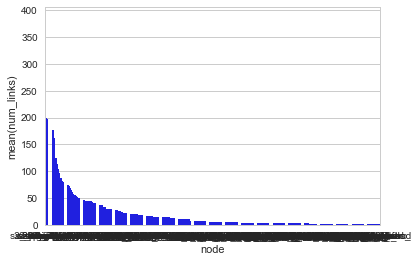

In [69]:
##################### Show a bar chart of nodes and the link distribution ###################
sns.set_style("whitegrid")
ax = sns.barplot(x="node", y="num_links", data=distr_df_hist, color="blue")
sns.plt.show()

In [10]:
# dump transformed dataset to csv file
df_transformed.to_csv('./data/power-page-flow-transformed-data.csv', na_rep = 'None', index = False)

In [11]:
# count the number of unique source and target pairs
df_traffic_pairs = df_transformed.groupby(['source', 'target']).size().reset_index().rename(columns={0:'value'})
# df_traffic_pairs = df_traffic_pairs[df_traffic_pairs['value'] > 1]
df_traffic_pairs

,source,target,value
0,FAQheart,FAQspage#5,1
1,FAQpain,s2sendingmessages#2,1
2,FAQspage,linkspage,1
3,FAQspage,loggingout,1
4,FAQspage,weighingFAQ,1
5,FAQspage#1,faqtechnical,1
6,FAQspage#1,loggingout,1
7,FAQspage#1,meettheteam,1
8,FAQspage#1,myprogresspage#1,1
9,FAQspage#2,FAQspage#3,1


In [288]:
# aggregated stuff
aggr_df_traffic_pairs = aggr_df_transformed.groupby(['source', 'target']).size().reset_index().rename(columns={0:'value'})
# aggr_df_traffic_pairs = aggr_df_traffic_pairs[df_traffic_pairs['value'] > 1]
show = aggr_df_traffic_pairs.sort_values('value', ascending=False)
aggr_df_traffic_pairs = aggr_df_traffic_pairs[aggr_df_traffic_pairs['source'] != aggr_df_traffic_pairs['target']]
aggr_df_traffic_pairs.sort_values('value', ascending=False)

# Filtering
aggr_df_traffic_pairs = aggr_df_traffic_pairs[aggr_df_traffic_pairs['value'] > 10]
print(aggr_df_traffic_pairs.shape)
aggr_df_traffic_pairs.sort_values('value', ascending=False)

(92, 3)


,source,target,value
103,homepage,login,153
164,login,welcomeback,95
712,welcomeback,s2weight,91
447,s2reviewgoals,s2newgoal,85
398,s2changeplan,s2_s1goaldecision,80
438,s2newgoal,s2changeplan,74
380,s2_s1goaldecision,s2_s2newplans,69
301,reviewfinish,s2sessionchoice,62
491,s2weight,wplost,61
715,wplost,s2reviewgoals,60


In [289]:
# Only include nodes that appear in the traffic pairs list
aggr_nodes = pd.DataFrame(columns=['name'])
aggr_nodes['name'] = pd.concat([aggr_df_traffic_pairs['source'], aggr_df_traffic_pairs['target']]).drop_duplicates()
aggr_nodes
print(aggr_nodes)

# save to list
aggr_nodes_list = aggr_nodes.to_dict(orient='record')
print(len(aggr_nodes_list))

                      name
17                   Tools
32             calexamples
41           chooseeatplan
43             choselowcal
49              chosenplan
63              entersteps
68               fooddiary
79             goalsetting
81         goalsetting3cal
88            habits_links
103               homepage
108            ifthenplans
110          ifthenplans2_
111  ifthenplansstoriescal
113        lastweekgoalspa
114          lessmotivated
155                  login
165            loginfailed
169                 lowcal
173            lowcalideas
179         lowcaloriefood
185                lowcarb
189            lowcarbfood
193           lowcarbideas
202            mixfeedback
219         myprogresspage
220           myweightloss
223      nocaloriecounting
224           nostrictdiet
230           pagoalreview
..                     ...
449      s2sendingmessages
480          s2stayontrack
481         s2supportintro
482         s2supportother
484       s2supportwebsite
4

In [290]:
# store traffic pairs as a list
traffic_pairs_list = df_traffic_pairs.to_dict(orient='record')

In [291]:
# store aggr traffic pairs as a list
aggr_traffic_pairs_list = aggr_df_traffic_pairs.to_dict(orient='record')
len(aggr_traffic_pairs_list)
print(aggr_traffic_pairs_list)

[{'value': 14, 'source': 'Tools', 'target': 'lowcaloriefood'}, {'value': 11, 'source': 'calexamples', 'target': 's2_s2goalchange'}, {'value': 22, 'source': 'chooseeatplan', 'target': 'lowcal'}, {'value': 17, 'source': 'chooseeatplan', 'target': 'lowcarb'}, {'value': 15, 'source': 'choselowcal', 'target': 's1end'}, {'value': 14, 'source': 'chosenplan', 'target': 'choselowcal'}, {'value': 39, 'source': 'entersteps', 'target': 'stepfeedback'}, {'value': 14, 'source': 'fooddiary', 'target': 'goalsetting3cal'}, {'value': 20, 'source': 'goalsetting', 'target': 'fooddiary'}, {'value': 15, 'source': 'goalsetting3cal', 'target': 'ifthenplans'}, {'value': 11, 'source': 'habits_links', 'target': 'habits_end'}, {'value': 153, 'source': 'homepage', 'target': 'login'}, {'value': 21, 'source': 'homepage', 'target': 'registration'}, {'value': 18, 'source': 'ifthenplans', 'target': 'ifthenplans2_'}, {'value': 13, 'source': 'ifthenplans', 'target': 'ifthenplansstoriescal'}, {'value': 19, 'source': 'ifth

In [292]:
# count the number times a source page appears (visits)
source_visits = df_transformed.groupby('source').size().reset_index().rename(columns={'source': 'name', 0: 'visits'})
# source_visits = source_visits[source_visits['name'].str.contains('#')]
source_visits

,name,visits
0,FAQheart,1
1,FAQpain,1
2,FAQspage,4
3,FAQspage#1,4
4,FAQspage#2,4
5,FAQspage#3,2
6,FAQspage#4,1
7,FAQspage#5,1
8,Tools,18
9,Tools#1,11


In [293]:
aggr_source_visits = aggr_df_transformed.groupby('source').size().reset_index().rename(columns={'source': 'name', 0: 'visits'})
# source_visits = source_visits[source_visits['name'].str.contains('#')]

aggr_source_visits = aggr_source_visits[aggr_source_visits['visits'] > 30]
# aggr_source_visits.sort_values('visits', ascending=False)
# aggr_source_visits

In [294]:
# store pages and their number of visits as a list 
page_list = source_visits.to_dict(orient='records')

In [295]:
# store aggr pages and their number of visits as a list 
aggr_page_list = aggr_source_visits.to_dict(orient='records')

In [296]:
# create a helper mapper dictionary for querying its index in the page list
nodes_dict_map = {}
for index, page in enumerate(page_list):
    nodes_dict_map[page['name']] = index

In [297]:
# aggr - create a helper mapper dictionary for querying its index in the page list
aggr_nodes_dict_map = {}
for index, page in enumerate(aggr_nodes_list):
    aggr_nodes_dict_map[page['name']] = index
aggr_nodes_dict_map

{'Tools': 0,
 'calexamples': 1,
 'chooseeatplan': 2,
 'choselowcal': 3,
 'chosenplan': 4,
 'entersteps': 5,
 'fooddiary': 6,
 'goalsetting': 7,
 'goalsetting3cal': 8,
 'habits_end': 73,
 'habits_links': 9,
 'homepage': 10,
 'ifthenplans': 11,
 'ifthenplans2_': 12,
 'ifthenplansstoriescal': 13,
 'lastweekgoalspa': 14,
 'lessmotivated': 15,
 'login': 16,
 'loginfailed': 17,
 'lowcal': 18,
 'lowcalideas': 19,
 'lowcaloriefood': 20,
 'lowcarb': 21,
 'lowcarbfood': 22,
 'lowcarbideas': 23,
 'mixfeedback': 24,
 'myprogresspage': 25,
 'myweightloss': 26,
 'nocaloriecounting': 27,
 'nostrictdiet': 28,
 'pagoalreview': 29,
 'pamixchange': 30,
 'pawalkbarriers': 31,
 'pawalkchange': 32,
 'pawalkplans': 33,
 'progresschart': 34,
 'q_followup_8wk': 35,
 'q_therapist': 75,
 'q_weight': 36,
 'reasonstoloseweight': 37,
 'registration': 38,
 'registrationfinish': 39,
 'reviewfinish': 40,
 's1end': 41,
 's1finalpage': 76,
 's1links': 42,
 's1mygoals': 43,
 's2_s1goaldecision': 44,
 's2_s2goalchange': 4

In [298]:
# create a list of dict with source and target represented by their respective index in the page list
traffic_pairs_with_index = []
for pair in traffic_pairs_list:
    traffic_pairs_with_index.append({
        'source': nodes_dict_map[pair['source']],
        'target': nodes_dict_map[pair['target']],
        'value': pair['value']
    })

In [299]:
# aggr - create a list of dict with source and target represented by their respective index in the page list
aggr_traffic_pairs_with_index = []
for pair in aggr_traffic_pairs_list:
    aggr_traffic_pairs_with_index.append({
        'source': aggr_nodes_dict_map[pair['source']],
        'target': aggr_nodes_dict_map[pair['target']],
        'value': pair['value']
    })
aggr_traffic_pairs_with_index

[{'source': 0, 'target': 20, 'value': 14},
 {'source': 1, 'target': 45, 'value': 11},
 {'source': 2, 'target': 18, 'value': 22},
 {'source': 2, 'target': 21, 'value': 17},
 {'source': 3, 'target': 41, 'value': 15},
 {'source': 4, 'target': 3, 'value': 14},
 {'source': 5, 'target': 64, 'value': 39},
 {'source': 6, 'target': 8, 'value': 14},
 {'source': 7, 'target': 6, 'value': 20},
 {'source': 8, 'target': 11, 'value': 15},
 {'source': 9, 'target': 73, 'value': 11},
 {'source': 10, 'target': 16, 'value': 153},
 {'source': 10, 'target': 38, 'value': 21},
 {'source': 11, 'target': 12, 'value': 18},
 {'source': 11, 'target': 13, 'value': 13},
 {'source': 12, 'target': 43, 'value': 19},
 {'source': 13, 'target': 11, 'value': 13},
 {'source': 14, 'target': 40, 'value': 23},
 {'source': 15, 'target': 37, 'value': 18},
 {'source': 16, 'target': 17, 'value': 26},
 {'source': 16, 'target': 74, 'value': 16},
 {'source': 16, 'target': 69, 'value': 95},
 {'source': 17, 'target': 16, 'value': 23},
 

In [300]:
# initial representation of flow dict
flow_dict = {
    'nodes': [{'name': '', 'visits': 0, 'avg_page_duration': 0}],
    'links': [{'source': 0, 'target': 1, 'value': 0, 'user_number': []}]
}

In [301]:
# aggr - initial representation of flow dict
aggr_flow_dict = {
    'nodes': [{'name': '', 'visits': 0, 'avg_page_duration': 0}],
    'links': [{'source': 0, 'target': 1, 'value': 0, 'user_number': []}]
}

In [302]:
flow_dict['nodes'] = page_list
flow_dict['links'] = traffic_pairs_with_index

In [303]:
# aggr
aggr_flow_dict = {}
aggr_flow_dict['nodes'] = aggr_nodes_list
aggr_flow_dict['links'] = aggr_traffic_pairs_with_index

In [304]:
with open('./data/page-flow.json', 'w') as fp:
    json.dump(flow_dict, fp, sort_keys=True, indent=2)

In [305]:
# aggr
with open('./data/aggr-page-flow.json', 'w') as fp:
    json.dump(aggr_flow_dict, fp, sort_keys=True, indent=2)

In [306]:
print(len(aggr_flow_dict['nodes']))
print(len(aggr_flow_dict['links']))

82
92


In [307]:
# find cyclic data
cyclic_links = []
for link in aggr_traffic_pairs_with_index:
    for other_link in aggr_traffic_pairs_with_index:
        if link['target'] == other_link['source'] and other_link['target'] == link['source']:
            if link['value'] >= other_link['value']:
                cyclic_links.append(other_link)
print(cyclic_links)
print(len(cyclic_links))

[{'value': 13, 'source': 13, 'target': 11}, {'value': 13, 'source': 11, 'target': 13}, {'value': 23, 'source': 17, 'target': 16}, {'value': 14, 'source': 20, 'target': 19}, {'value': 11, 'source': 22, 'target': 23}, {'value': 11, 'source': 1, 'target': 45}, {'value': 27, 'source': 68, 'target': 71}]
7


In [308]:
# keep only non-cyclic data
non_cyclic_links = []
for link in aggr_traffic_pairs_with_index:
    same = False
    for cyclic_link in cyclic_links:
        if cyclic_link == link:
            same = True
    if not same:
        non_cyclic_links.append(link)
print(len(non_cyclic_links))

85


In [309]:
non_cyclic_flow_dict = {}
non_cyclic_flow_dict['nodes'] = aggr_nodes_list
non_cyclic_flow_dict['links'] = non_cyclic_links

# non_cyclic
with open('./data/non-cyclic-aggr-page-flow.json', 'w') as fp:
    json.dump(non_cyclic_flow_dict, fp, sort_keys=True, indent=2)

In [310]:
non_cyclic_flow_dict['nodes'][29]

{'name': 'pagoalreview'}

In [311]:
non_cyclic_flow_dict['nodes'][50]

{'name': 's2newgoal'}